In [26]:
import xarray as xr
import pandas as pd
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import numpy as np
import matplotlib.cm as cm
import cmocean.cm as cmo
import intake
import numcodecs
import gribscan
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import scipy.spatial

In [2]:
from dask.distributed import Client
import dask
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

client = Client(n_workers=10, threads_per_worker=1, memory_limit='20GB')
client.run(numcodecs.register_codec, gribscan.RawGribCodec, "gribscan.rawgrib")


{'tcp://127.0.0.1:33285': None,
 'tcp://127.0.0.1:34777': None,
 'tcp://127.0.0.1:36575': None,
 'tcp://127.0.0.1:38185': None,
 'tcp://127.0.0.1:39195': None,
 'tcp://127.0.0.1:40073': None,
 'tcp://127.0.0.1:41511': None,
 'tcp://127.0.0.1:42213': None,
 'tcp://127.0.0.1:44405': None,
 'tcp://127.0.0.1:45137': None}

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 186.26 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44503,Workers: 10
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,Total threads: 10
Started: Just now,Total memory: 186.26 GiB
Comm: tcp://127.0.0.1:45137,Total threads: 1
Dashboard: /user/a270088/levante-spawner-preset//proxy/41417/status,Memory: 18.63 GiB
Nanny: tcp://127.0.0.1:45043,


In [4]:
cat = intake.open_catalog("../catalog.yaml")

In [5]:
run = cat.IFS["tco3999-ng5"]

In [6]:
data = run.ICMGG_atm2d.to_dask()

In [7]:
data

<xarray.Dataset>
Dimensions:  (time: 5401, value: 64144000, level: 5)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(64144000,), meta=np.ndarray>
  * level    (level) int64 1 2 3 4 5
    lon      (value) float64 dask.array<chunksize=(64144000,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2020-09-01
Dimensions without coordinates: value
Data variables: (12/81)
    100si    (time, value) float64 dask.array<chunksize=(1, 64144000), meta=np.ndarray>
    100u     (time, value) float64 dask.array<chunksize=(1, 64144000), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 64144000), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 64144000), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 64144000), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 64144000), meta=np.ndarray>
    ...       ...
    uvb      (time, value) float64 dask.array<chunksize=(1, 64144000), meta=np.ndarray>
    vike     (time, value) float64 dask.array<chunksize=(1, 64144000), meta=np.ndarray>
    vipie    (time, value) float64 dask.array<chunksize=(1, 64144000), meta=np.ndarray>
    vipile   (time, value) float64 dask.array<chunksize=(1, 64144000), meta=np.ndarray>
    vithe    (time, value) float64 dask.array<chunksize=(1, 64144000), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 64144000), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [9]:
data['sst']

<xarray.DataArray 'sst' (time: 5401, value: 64144000)>
dask.array<open_dataset-247cb653fe75754ec8b2033d6fccf62esst, shape=(5401, 64144000), dtype=float64, chunksize=(1, 64144000), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(64144000,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(64144000,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2020-09-01
Dimensions without coordinates: value
Attributes:
    paramId:                    34
    dataType:                   fc
    numberOfPoints:             64144000
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    gridType:                   reduced_gg
    shortName:                  sst
    units:                      K
    name:                       Sea surface temperature
    cfVarName:                  sst
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

In [10]:
data['sst'].resample(time='1D').mean(dim='time')

<xarray.DataArray 'sst' (time: 226, value: 64144000)>
dask.array<stack, shape=(226, 64144000), dtype=float64, chunksize=(1, 64144000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2020-09-01
    lat      (value) float64 dask.array<chunksize=(64144000,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(64144000,), meta=np.ndarray>
Dimensions without coordinates: value

In [11]:
data['sst'].resample(time='1D').mean(dim='time').sel(time='2020-03')

<xarray.DataArray 'sst' (time: 31, value: 64144000)>
dask.array<getitem, shape=(31, 64144000), dtype=float64, chunksize=(1, 64144000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-03-01 2020-03-02 ... 2020-03-31
    lat      (value) float64 dask.array<chunksize=(64144000,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(64144000,), meta=np.ndarray>
Dimensions without coordinates: value

Compute 5 days of daily data from hourly data.

In [12]:
march = data['sst'].resample(time='1D').mean(dim='time').sel(time=slice('2020-03-01', '2020-03-05')).compute()

Interpolate first daily mean from result to regular grid with nearest neighbor:

In [21]:
model_lon = data.lon.values
model_lat = data.lat.values
model_lon = np.where(model_lon>180, model_lon-360, model_lon)

In [22]:
lon = np.linspace(-180, 180, 360)
lat = np.linspace(-30, 30, 60)
lon2, lat2 = np.meshgrid(lon, lat)

In [23]:
march

<xarray.DataArray 'sst' (time: 5, value: 64144000)>
array([[271.45996094, 271.45996094, 271.45996094, ..., 273.16210938,
        273.16113281, 273.16113281],
       [271.45996094, 271.45996094, 271.45996094, ..., 273.16210938,
        273.16113281, 273.16113281],
       [271.45996094, 271.45996094, 271.45996094, ..., 273.16210938,
        273.16113281, 273.16113281],
       [271.45996094, 271.45996094, 271.45996094, ..., 273.16210938,
        273.16113281, 273.16113281],
       [271.45996094, 271.45996094, 271.45996094, ..., 273.16210938,
        273.16113281, 273.16113281]])
Coordinates:
  * time     (time) datetime64[ns] 2020-03-01 2020-03-02 ... 2020-03-05
    lat      (value) float64 89.98 89.98 89.98 89.98 ... -89.98 -89.98 -89.98
    lon      (value) float64 0.0 18.0 36.0 54.0 72.0 ... 288.0 306.0 324.0 342.0
Dimensions without coordinates: value

In [24]:
points_icon = np.vstack((model_lon, model_lat)).T
nn_interpolation = NearestNDInterpolator(points_icon, march[0,:].values)
interpolated_nn = nn_interpolation((lon2, lat2))

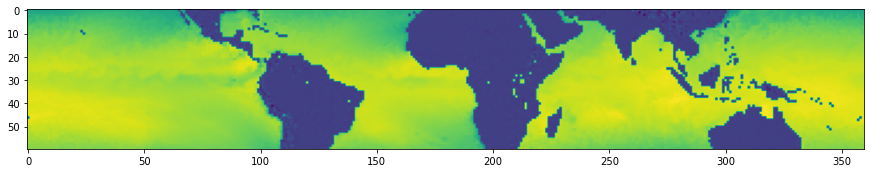

In [25]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

Will take you some minutes (like 10) - have some respect to 60M data points :)

In [28]:
delaunay = scipy.spatial.Delaunay(points_icon)

but you will be able to use it for furhte interpolations

In [38]:
%%time
nn_interpolation_linear = LinearNDInterpolator(delaunay, march[0,:].values)
interpolated_nn_linear = nn_interpolation_linear((lon2, lat2))

CPU times: user 12min 39s, sys: 5min 31s, total: 18min 10s
Wall time: 8min 51s


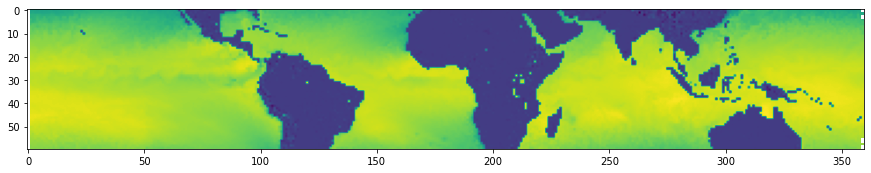

In [39]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn_linear))

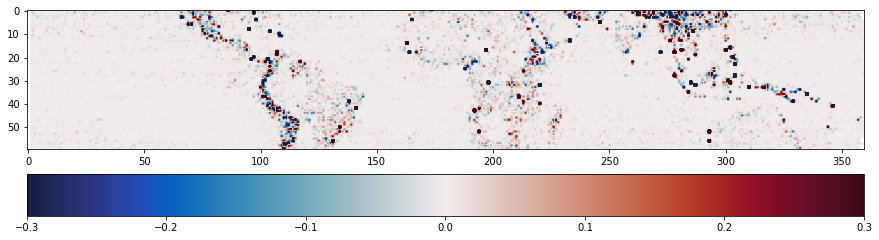

In [47]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn_linear-interpolated_nn), vmin=-0.3, vmax=0.3, cmap=cmo.balance)
plt.colorbar(orientation='horizontal', pad=0.03)

Next interpolation (for different time step) is much faster

In [48]:
%%time
nn_interpolation_linear2 = LinearNDInterpolator(delaunay, march[2,:].values)
interpolated_nn_linea2r = nn_interpolation_linear2((lon2, lat2))

CPU times: user 774 ms, sys: 13.6 ms, total: 788 ms
Wall time: 743 ms


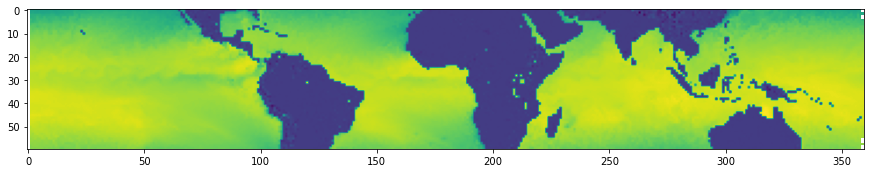

In [49]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn_linea2r))